# THE SIMPSONS 
## Image Classification📺

### This is my one of the favourite cartoon😉😝

Using around 42000 pictures of 42 characters of the Simpsons to teach the neural network and testing the result on pictures it hasn't seen before.

![Simpsons](https://ntvb.tmsimg.com/assets/p18722572_b_h8_ak.jpg?w=960&h=540)



## Data preprocessing and visualization

In [5]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# Create a list with the filepaths
train_dir = Path('../input/the-simpsons-characters-dataset/simpsons_dataset')
filepaths = list(train_dir.glob(r'**/*.jpg'))

# Create a DataFrame with the filepaths and the labels of the picture
df = proc_img(filepaths)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

2022-04-04 05:38:40.695050: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Number of pictures: 41866

Number of different labels: 42

Labels: ['bart_simpson' 'edna_krabappel' 'apu_nahasapeemapetilon' 'ned_flanders'
 'marge_simpson' 'abraham_grampa_simpson' 'kent_brockman'
 'charles_montgomery_burns' 'chief_wiggum' 'milhouse_van_houten'
 'sideshow_bob' 'waylon_smithers' 'principal_skinner' 'comic_book_guy'
 'martin_prince' 'moe_szyslak' 'homer_simpson' 'lisa_simpson'
 'professor_john_frink' 'nelson_muntz' 'lenny_leonard' 'mayor_quimby'
 'selma_bouvier' 'fat_tony' 'krusty_the_clown' 'patty_bouvier'
 'rainier_wolfcastle' 'carl_carlson' 'miss_hoover' 'gil' 'ralph_wiggum'
 'groundskeeper_willie' 'barney_gumble' 'maggie_simpson' 'troy_mcclure'
 'agnes_skinner' 'sideshow_mel' 'lionel_hutz' 'snake_jailbird' 'otto_mann'
 'cletus_spuckler' 'disco_stu']


,Filepath,Label
0,../input/the-simpsons-characters-dataset/simps...,bart_simpson
1,../input/the-simpsons-characters-dataset/simps...,edna_krabappel
2,../input/the-simpsons-characters-dataset/simps...,apu_nahasapeemapetilon
3,../input/the-simpsons-characters-dataset/simps...,bart_simpson
4,../input/the-simpsons-characters-dataset/simps...,ned_flanders


![gif](https://www.icegif.com/wp-content/uploads/2021/11/icegif-712.gif)

## Visualize 40 pictures from the dataset

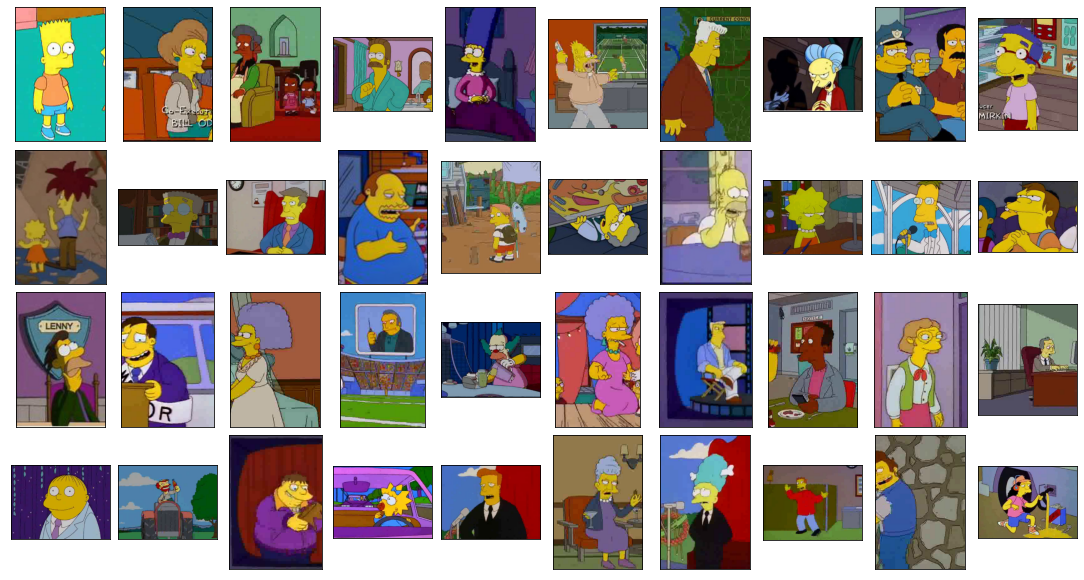

In [6]:
df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display 40 picture of the dataset
fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
#     ax.set_title(df_unique.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

## Load the images with a generator

In [7]:
# Splitting the data into train test and split
train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)

In [8]:
# Generating image generator for training data
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
                    validation_split=0.2
                )

# Generating image generatir for testing data
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
                )

In [20]:
train_images = train_generator.flow_from_dataframe(
    rescale = 1/255,
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    rescale = 1/255,
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    rescale=1/255,
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 26794 validated image filenames belonging to 42 classes.
Found 6698 validated image filenames belonging to 42 classes.
Found 8374 validated image filenames belonging to 42 classes.


## Loading the pre-trained model (MobileNetV2)

In [27]:
# Load the pretained model
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

for layer in mobilenet.layers:
    layer.trainable = False

In [29]:
img,label = next(train_images)
img.shape

(32, 224, 224, 3)

In [32]:
inputs = mobilenet.input

x = mobilenet.output
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)

outputs = tf.keras.layers.Dense(42, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    steps_per_epoch = 300,
    batch_size=64,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor = 'val_loss',
            patience = 8
        )
    ]
)

Epoch 1/50
300/300 [==============================] - 132s 434ms/step - loss: 3.5630 - accuracy: 0.0821 - val_loss: 2.8980 - val_accuracy: 0.1735
Epoch 2/50
300/300 [==============================] - 87s 290ms/step - loss: 2.7893 - accuracy: 0.2149 - val_loss: 2.4806 - val_accuracy: 0.3176
Epoch 3/50
300/300 [==============================] - 77s 258ms/step - loss: 2.4234 - accuracy: 0.3182 - val_loss: 2.1390 - val_accuracy: 0.4258
Epoch 4/50
300/300 [==============================] - 72s 242ms/step - loss: 2.1322 - accuracy: 0.4162 - val_loss: 2.0396 - val_accuracy: 0.4464
Epoch 5/50
300/300 [==============================] - 68s 226ms/step - loss: 2.0085 - accuracy: 0.4585 - val_loss: 1.8222 - val_accuracy: 0.5040
Epoch 6/50
300/300 [==============================] - 65s 218ms/step - loss: 1.8830 - accuracy: 0.4922 - val_loss: 1.7357 - val_accuracy: 0.5346
Epoch 7/50
300/300 [==============================] - 63s 210ms/step - loss: 1.7533 - accuracy: 0.5279 - val_loss: 1.6305 - val_a

In [33]:
model.evaluate(test_images)

262/262 [==============================] - 74s 284ms/step - loss: 1.2860 - accuracy: 0.6691


[1.2860127687454224, 0.6690948009490967]

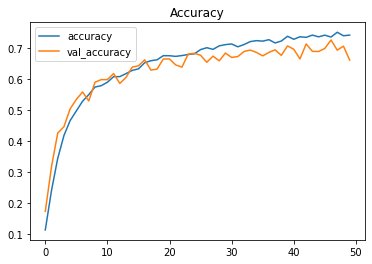

In [34]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy')
plt.show()

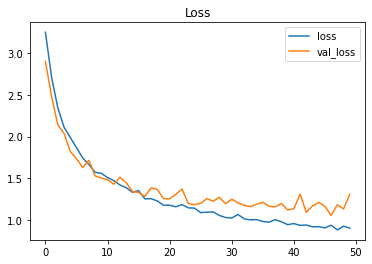

In [35]:
# For loss
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title('Loss')
plt.show()

- Both the graphs are tellig us the **accuracy and loss** of training and validatio data. The above results are satisfied us indeed.

In [36]:
# Visualize the result
pred = model.predict(test_images)
pred = np.argmax(pred, axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['abraham_grampa_simpson', 'ralph_wiggum', 'chief_wiggum', 'comic_book_guy', 'chief_wiggum']


In [37]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test, pred)
print(f"Accuracy on the test set: {acc*100:.2f}%")

Accuracy on the test set: 66.91%


In [38]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.66      0.72      0.69       391
           agnes_skinner       1.00      0.00      0.00        14
  apu_nahasapeemapetilon       0.90      0.66      0.76       230
           barney_gumble       0.38      0.12      0.18        52
            bart_simpson       0.95      0.57      0.71       529
            carl_carlson       0.87      0.28      0.43        46
charles_montgomery_burns       0.63      0.75      0.68       476
            chief_wiggum       0.60      0.87      0.71       379
         cletus_spuckler       0.50      0.04      0.08        24
          comic_book_guy       0.73      0.71      0.72       215
               disco_stu       1.00      0.00      0.00         3
          edna_krabappel       0.72      0.61      0.66       190
                fat_tony       0.17      0.31      0.22        13
                     gil       0.00      0.00      0.00         8
    groun

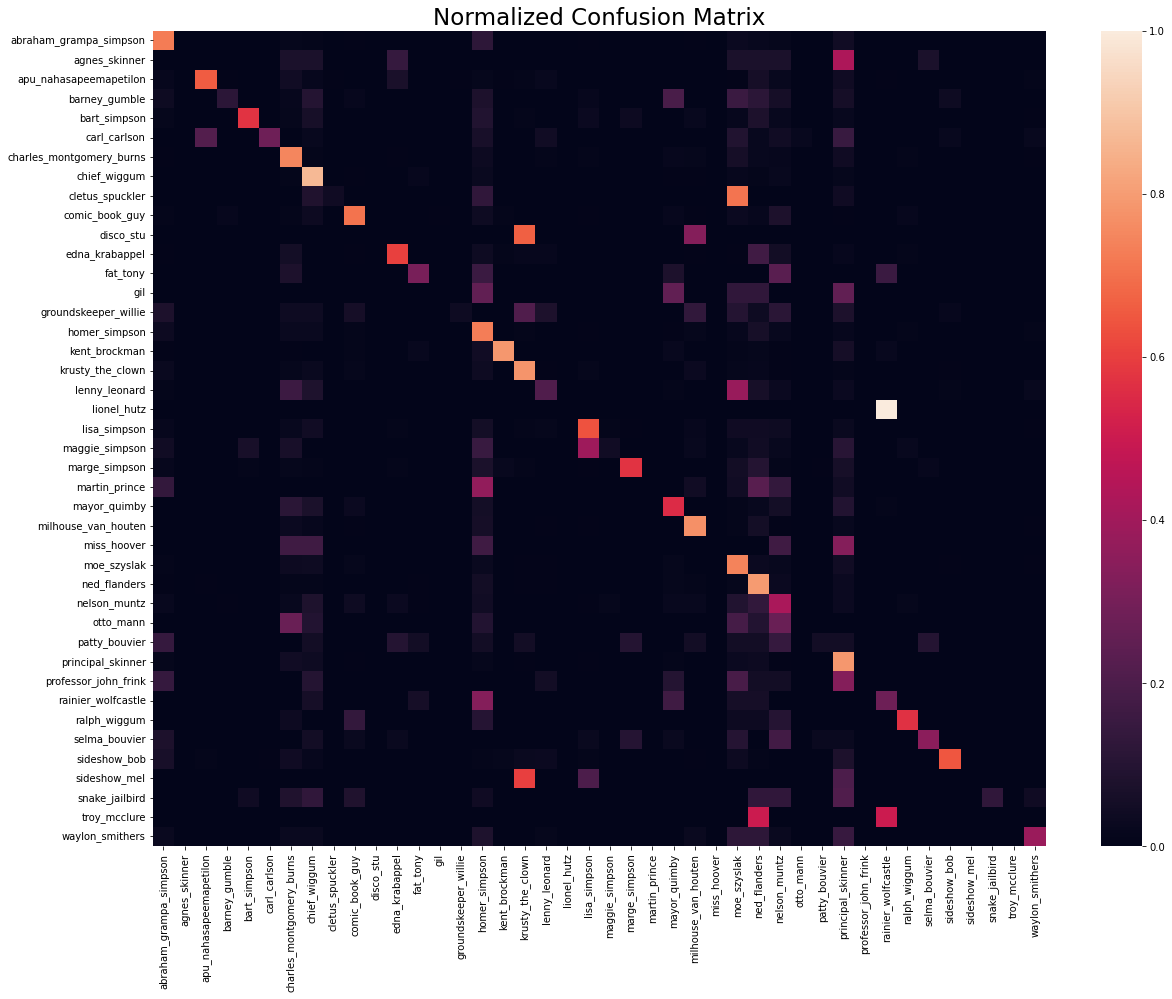

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

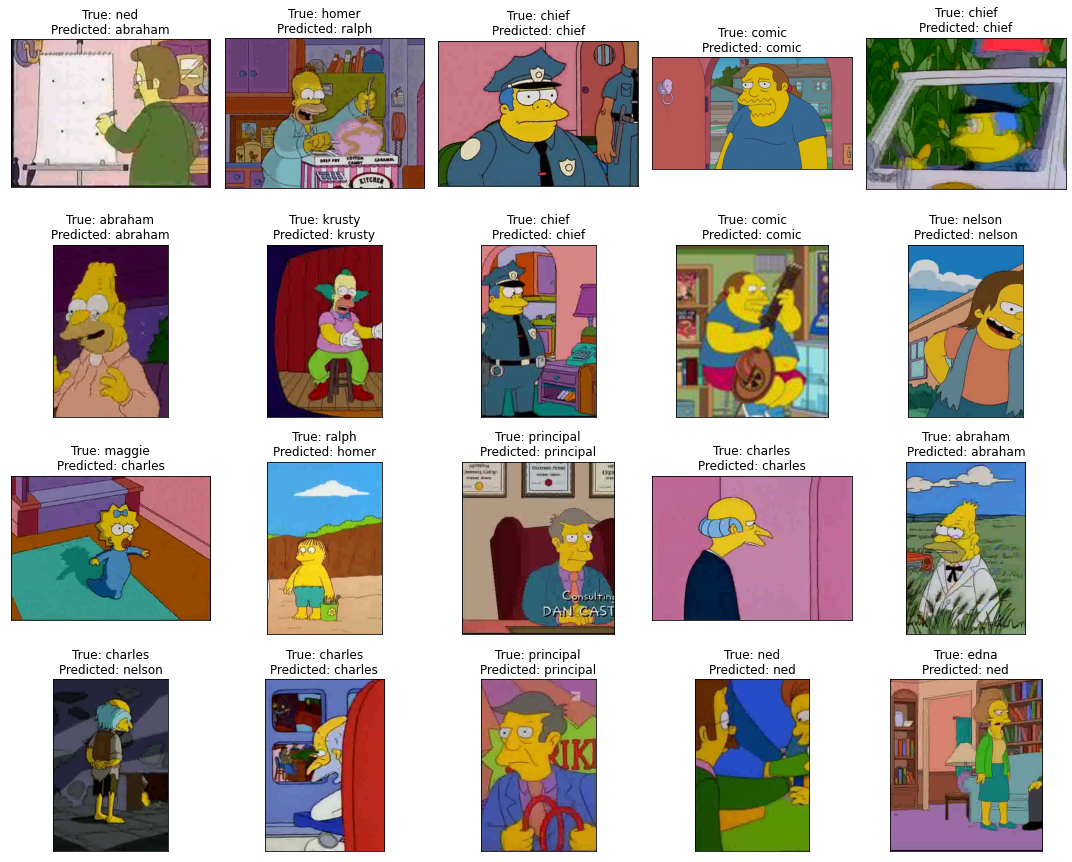

In [40]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()